In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 4.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=02d24bc304680ec59e7239caedfb98f06ee2a369a95cac1c2e9fda27dad5a2d4
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


First 5 rows of the fetched data:
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195  5232.200195   
2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902  5277.899902   
2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805  5281.799805   
2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098  5263.100098   
2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000  5244.750000   

            Volume  
Date                
2010-01-04       0  
2010-01-05       0  
2010-01-06       0  
2010-01-07       0  
2010-01-08       0  


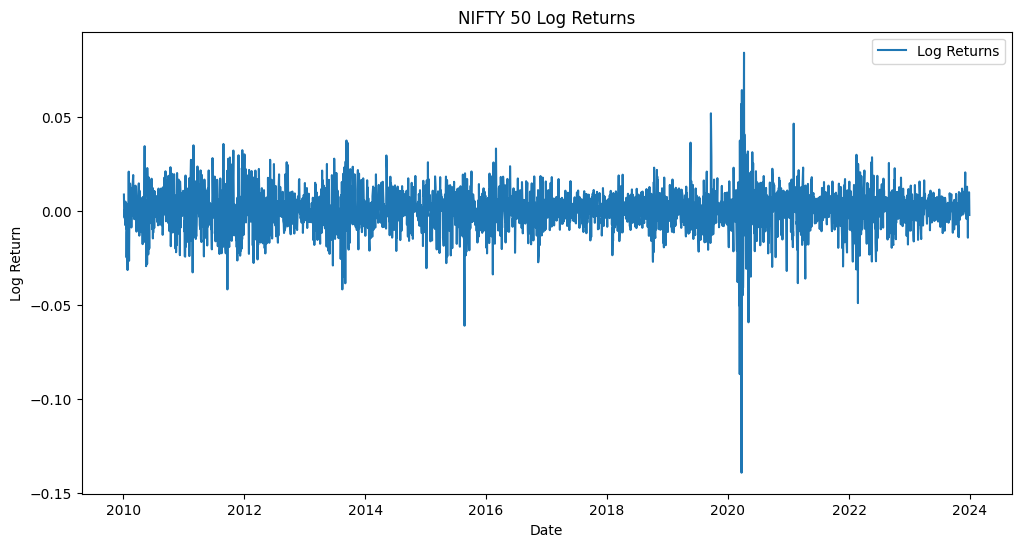

Number of observations: 3433


In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Fetch NIFTY 50 data
ticker = '^NSEI'  # NIFTY 50 ticker symbol in Yahoo Finance
start_date = '2010-01-01'
end_date = '2023-12-31'

# Download historical data
data = yf.download(ticker, start=start_date, end=end_date)

# Check if data is fetched
if data.empty:
    raise ValueError("No data fetched. Please check the ticker symbol and internet connection.")

# Display the first few rows
print("First 5 rows of the fetched data:")
print(data.head())

# Calculate daily log returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()  # Remove the first row with NaN

# Plot the log returns
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Log_Returns'], label='Log Returns')
plt.title('NIFTY 50 Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

# Extract log returns as a NumPy array
y = data['Log_Returns'].values
print(f"Number of observations: {len(y)}")


In [4]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_std = 10

phi_prior_a = 20
phi_prior_b = 1.5

sigma_eta_prior_alpha = 2
sigma_eta_prior_beta = 0.1

# Sampling functions for priors
def sample_prior_mu():
    return np.random.normal(mu_prior_mean, mu_prior_std)

def sample_prior_phi():
    # Sample from Beta and transform to (-1,1)
    beta_sample = np.random.beta(phi_prior_a, phi_prior_b)
    return 2 * beta_sample - 1

def sample_prior_sigma_eta():
    return np.sqrt(np.random.gamma(sigma_eta_prior_alpha, sigma_eta_prior_beta))

# Example sampling from priors
print("Sampling from priors:")
print(f"mu ~ N({mu_prior_mean}, {mu_prior_std}): {sample_prior_mu()}")
print(f"phi ~ Beta({phi_prior_a}, {phi_prior_b}) mapped to (-1,1): {sample_prior_phi()}")
print(f"sigma_eta ~ sqrt(Gamma({sigma_eta_prior_alpha}, {sigma_eta_prior_beta})): {sample_prior_sigma_eta()}")


Sampling from priors:
mu ~ N(0, 10): 13.507445495907163
phi ~ Beta(20, 1.5) mapped to (-1,1): 0.9655493815569205
sigma_eta ~ sqrt(Gamma(2, 0.1)): 0.5361881799276372


In [5]:
def calculate_log_likelihood(y, h, theta):
    mu, phi, sigma_eta = theta
    n = len(y)
    
    # Initialize log-likelihood
    log_likelihood = 0.0
    
    for t in range(n):
        # Returns likelihood
        log_likelihood += -0.5 * np.log(2 * np.pi) - 0.5 * h[t] - (y[t] ** 2) / (2 * np.exp(h[t]))
        
        # Volatility process likelihood
        if t == 0:
            # Assuming h_0 ~ N(mu, sigma_eta^2 / (1 - phi^2))
            var0 = sigma_eta ** 2 / (1 - phi ** 2)
            log_likelihood += -0.5 * np.log(2 * np.pi * var0) - ((h[t] - mu) ** 2) / (2 * var0)
        else:
            mean_ht = mu + phi * (h[t-1] - mu)
            log_likelihood += -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t] - mean_ht) ** 2) / (2 * sigma_eta ** 2)
    
    return log_likelihood


In [6]:
def gibbs_sampler(y, iterations, burn_in, priors, initial_params):
    """
    Perform Gibbs sampling for the Stochastic Volatility model.
    
    Parameters:
    - y: Observed log returns (numpy array)
    - iterations: Total number of MCMC iterations
    - burn_in: Number of burn-in iterations
    - priors: Dictionary containing prior parameters
    - initial_params: Dictionary containing initial parameter values
    
    Returns:
    - samples: Dictionary containing sampled parameters and latent volatilities
    """
    n = len(y)
    
    # Unpack priors
    mu_prior_mean = priors['mu_mean']
    mu_prior_std = priors['mu_std']
    
    phi_prior_a = priors['phi_a']
    phi_prior_b = priors['phi_b']
    
    sigma_eta_prior_alpha = priors['sigma_eta_alpha']
    sigma_eta_prior_beta = priors['sigma_eta_beta']
    
    # Initialize parameters
    mu = initial_params['mu']
    phi = initial_params['phi']
    sigma_eta = initial_params['sigma_eta']
    
    # Initialize latent volatilities
    h = np.zeros(n)
    h[0] = np.random.normal(mu, sigma_eta / np.sqrt(1 - phi ** 2))
    for t in range(1, n):
        h[t] = mu + phi * (h[t-1] - mu) + np.random.normal(0, sigma_eta)
    
    # Store samples
    samples_mu = []
    samples_phi = []
    samples_sigma_eta = []
    samples_h = []
    
    for it in range(iterations):
        # --- Step 1: Sample h_t given mu, phi, sigma_eta, y ---
        # Using a simple Metropolis-Hastings step for each h_t
        for t in range(n):
            # Current h_t
            current_ht = h[t]
            
            # Propose a new h_t
            proposal_ht = np.random.normal(current_ht, 0.1)  # Proposal variance can be tuned
            
            # Calculate log-likelihood ratio
            # For returns
            log_likelihood_current = -0.5 * h[t] - (y[t] ** 2) / (2 * np.exp(h[t]))
            log_likelihood_proposal = -0.5 * proposal_ht - (y[t] ** 2) / (2 * np.exp(proposal_ht))
            
            # For volatility process
            if t == 0:
                # Prior for h0
                var0 = sigma_eta ** 2 / (1 - phi ** 2)
                log_prior_current = -0.5 * np.log(2 * np.pi * var0) - ((h[t] - mu) ** 2) / (2 * var0)
                log_prior_proposal = -0.5 * np.log(2 * np.pi * var0) - ((proposal_ht - mu) ** 2) / (2 * var0)
            else:
                mean_ht = mu + phi * (h[t-1] - mu)
                log_prior_current = -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t] - mean_ht) ** 2) / (2 * sigma_eta ** 2)
                log_prior_proposal = -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((proposal_ht - mean_ht) ** 2) / (2 * sigma_eta ** 2)
            
            # For t > 0, also consider h_{t+1}
            if t < n - 1:
                mean_ht_plus = mu + phi * (h[t] - mu)
                log_prior_current += -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t+1] - mu - phi * (h[t] - mu)) ** 2) / (2 * sigma_eta ** 2)
                mean_ht_plus_proposal = mu + phi * (proposal_ht - mu)
                log_prior_proposal += -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t+1] - mu - phi * (proposal_ht - mu)) ** 2) / (2 * sigma_eta ** 2)
            
            # Compute acceptance probability
            log_accept_ratio = (log_likelihood_proposal + log_prior_proposal) - (log_likelihood_current + log_prior_current)
            accept_ratio = np.exp(log_accept_ratio)
            alpha = min(1, accept_ratio)
            
            # Accept or reject
            if np.random.uniform(0, 1) < alpha:
                h[t] = proposal_ht  # Accept the proposal
        
        # --- Step 2: Sample mu given h, phi, sigma_eta ---
        # Conditional posterior of mu is Normal
        sum_h = np.sum(h[1:] - phi * h[:-1])
        var_mu = 1 / (1 / (mu_prior_std ** 2) + phi ** 2 * (n - 1) / (sigma_eta ** 2))
        mean_mu = var_mu * (mu_prior_mean / (mu_prior_std ** 2) + phi * sum_h / (sigma_eta ** 2))
        mu = np.random.normal(mean_mu, np.sqrt(var_mu))
        
        # --- Step 3: Sample phi given h, mu, sigma_eta ---
        # Use Metropolis-Hastings for phi
        current_phi = phi
        proposal_phi = np.random.normal(current_phi, 0.01)  # Proposal std can be tuned
        
        # Ensure phi is in (-1, 1)
        if proposal_phi <= -1 or proposal_phi >= 1:
            proposal_phi = current_phi
        
        # Calculate log-posterior for current and proposal
        log_prior_current_phi = (phi_prior_a - 1) * np.log((current_phi + 1) / 2) + (phi_prior_b - 1) * np.log((1 - current_phi) / 2)
        log_prior_proposal_phi = (phi_prior_a - 1) * np.log((proposal_phi + 1) / 2) + (phi_prior_b - 1) * np.log((1 - proposal_phi) / 2)
        
        # Likelihood based on h
        residual_current = h[1:] - mu - current_phi * (h[:-1] - mu)
        residual_proposal = h[1:] - mu - proposal_phi * (h[:-1] - mu)
        
        log_likelihood_current_phi = -0.5 * np.sum((residual_current ** 2) / (sigma_eta ** 2))
        log_likelihood_proposal_phi = -0.5 * np.sum((residual_proposal ** 2) / (sigma_eta ** 2))
        
        # Compute acceptance probability
        log_accept_ratio_phi = (log_likelihood_proposal_phi + log_prior_proposal_phi) - (log_likelihood_current_phi + log_prior_current_phi)
        accept_ratio_phi = np.exp(log_accept_ratio_phi)
        alpha_phi = min(1, accept_ratio_phi)
        
        # Accept or reject
        if np.random.uniform(0, 1) < alpha_phi:
            phi = proposal_phi
        
        # --- Step 4: Sample sigma_eta given h, mu, phi ---
        # Conditional posterior of sigma_eta^2 is Gamma
        residuals = h[1:] - mu - phi * (h[:-1] - mu)
        shape_post = sigma_eta_prior_alpha + (len(residuals) / 2)
        rate_post = sigma_eta_prior_beta + 0.5 * np.sum(residuals ** 2)
        sigma_eta_sq = np.random.gamma(shape_post, 1 / rate_post)
        sigma_eta = np.sqrt(sigma_eta_sq)
        
        # Store samples after burn-in
        if it >= burn_in:
            samples_mu.append(mu)
            samples_phi.append(phi)
            samples_sigma_eta.append(sigma_eta)
            samples_h.append(h.copy())
        
        # Optional: Print progress
        if (it + 1) % 1000 == 0:
            print(f"Iteration {it + 1} completed.")
    
    # Convert samples_h to a NumPy array for easier handling
    samples_h = np.array(samples_h)
    
    # Return the collected samples
    samples = {
        'mu': np.array(samples_mu),
        'phi': np.array(samples_phi),
        'sigma_eta': np.array(samples_sigma_eta),
        'h': samples_h
    }
    
    return samples


In [7]:
# Define prior parameters
priors = {
    'mu_mean': 0,
    'mu_std': 10,
    'phi_a': 20,
    'phi_b': 1.5,
    'sigma_eta_alpha': 2,
    'sigma_eta_beta': 0.1
}

# Initial parameter guesses
initial_params = {
    'mu': 0,
    'phi': 0.95,
    'sigma_eta': 0.2
}

# Set MCMC parameters
iterations = 10000
burn_in = 2000

# Run Gibbs sampler
print("Starting Gibbs sampler...")
samples = gibbs_sampler(y, iterations, burn_in, priors, initial_params)
print("Gibbs sampler completed.")


Starting Gibbs sampler...
Iteration 1000 completed.
Iteration 2000 completed.
Iteration 3000 completed.
Iteration 4000 completed.
Iteration 5000 completed.
Iteration 6000 completed.
Iteration 7000 completed.
Iteration 8000 completed.
Iteration 9000 completed.
Iteration 10000 completed.
Gibbs sampler completed.


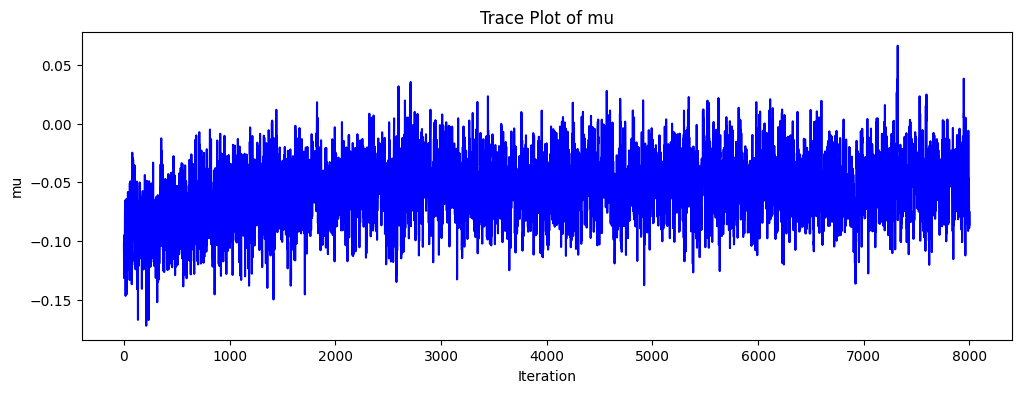

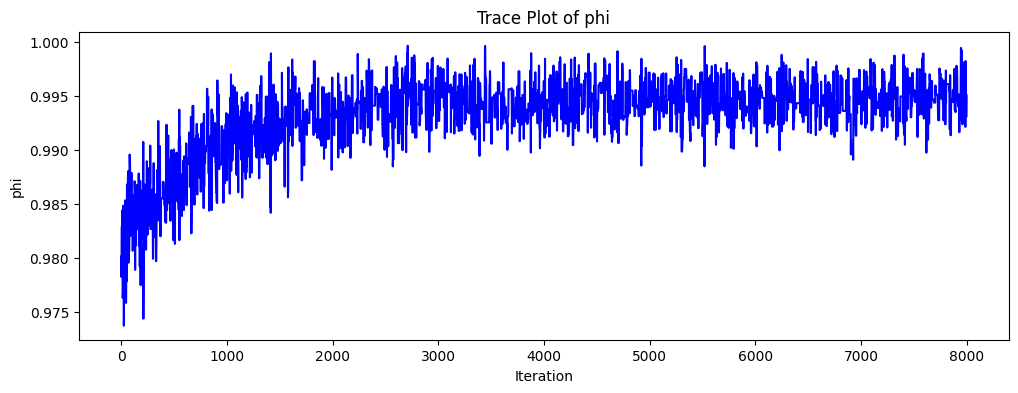

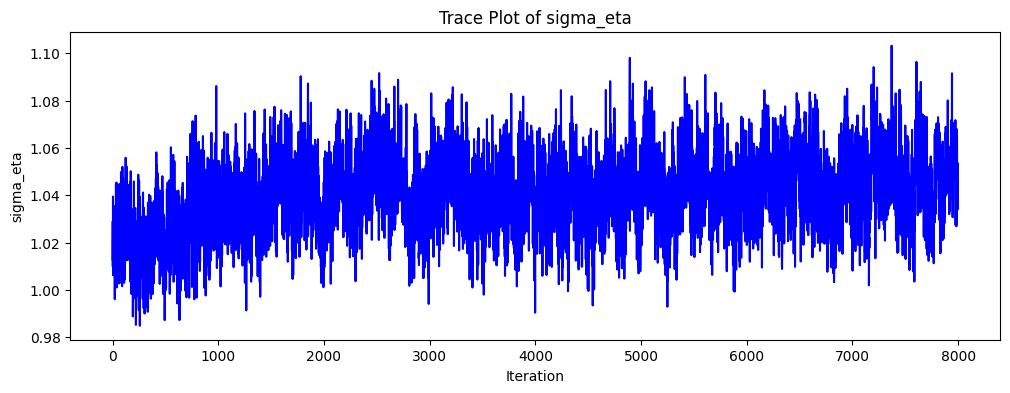

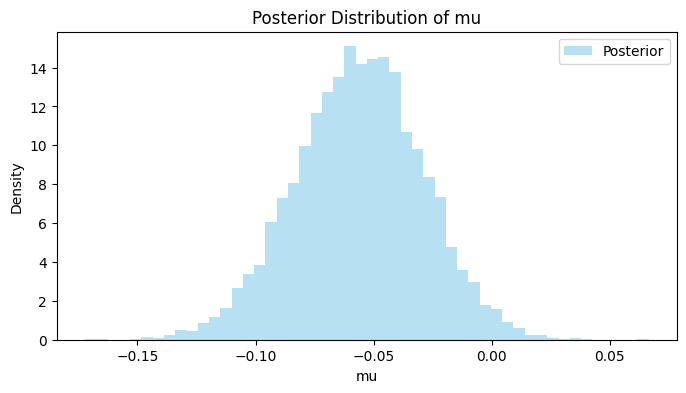

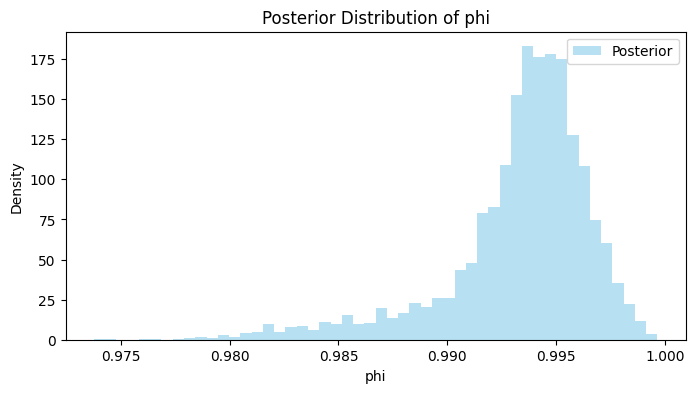

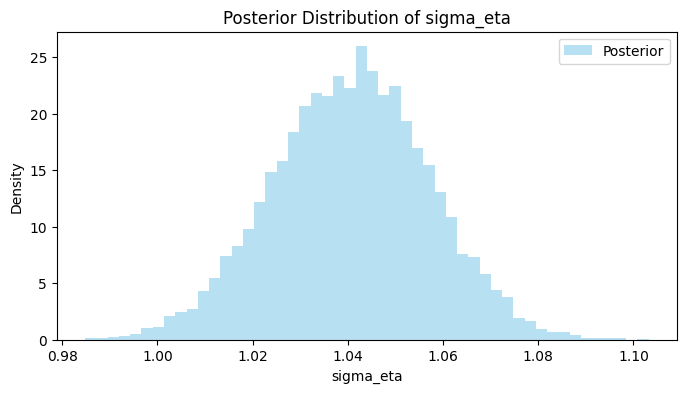

In [8]:
import matplotlib.pyplot as plt

# Function to plot trace plots
def plot_trace(samples, param_name):
    plt.figure(figsize=(12, 4))
    plt.plot(samples, color='blue')
    plt.title(f'Trace Plot of {param_name}')
    plt.xlabel('Iteration')
    plt.ylabel(param_name)
    plt.show()

# Function to plot posterior histograms
def plot_posterior(samples, param_name, true_value=None):
    plt.figure(figsize=(8, 4))
    plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', label='Posterior')
    if true_value is not None:
        plt.axvline(true_value, color='red', linestyle='--', label='True Value')
    plt.title(f'Posterior Distribution of {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Plot trace plots
plot_trace(samples['mu'], 'mu')
plot_trace(samples['phi'], 'phi')
plot_trace(samples['sigma_eta'], 'sigma_eta')

# Plot posterior distributions
plot_posterior(samples['mu'], 'mu')
plot_posterior(samples['phi'], 'phi')
plot_posterior(samples['sigma_eta'], 'sigma_eta')


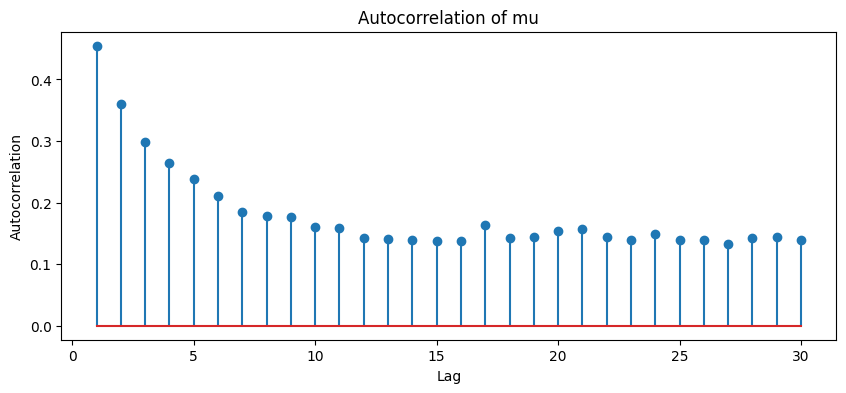

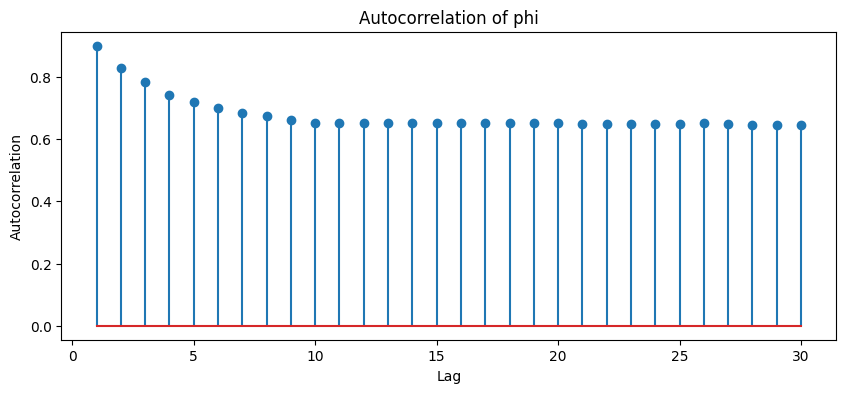

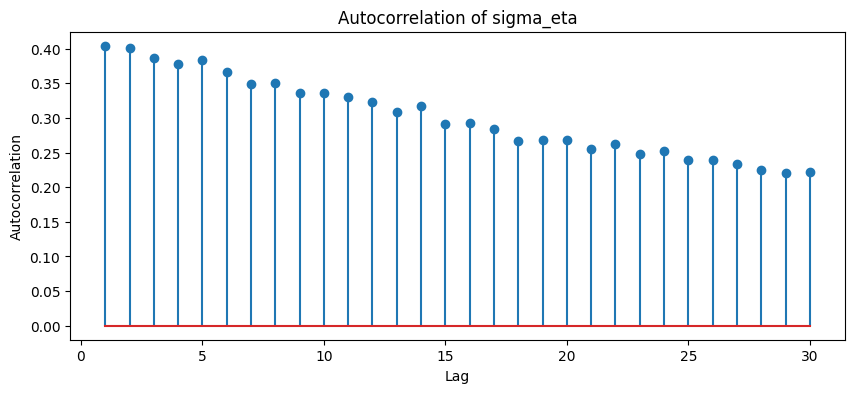

In [9]:
def plot_autocorrelation(samples, param_name, lags=30):
    autocorr = [np.corrcoef(samples[:-lag], samples[lag:])[0,1] for lag in range(1, lags+1)]
    plt.figure(figsize=(10, 4))
    plt.stem(range(1, lags+1), autocorr, use_line_collection=True)
    plt.title(f'Autocorrelation of {param_name}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

# Plot autocorrelation
plot_autocorrelation(samples['mu'], 'mu')
plot_autocorrelation(samples['phi'], 'phi')
plot_autocorrelation(samples['sigma_eta'], 'sigma_eta')


In [10]:
def summarize_posterior(samples, param_name):
    mean = np.mean(samples)
    median = np.median(samples)
    lower = np.percentile(samples, 2.5)
    upper = np.percentile(samples, 97.5)
    print(f"Posterior summary for {param_name}:")
    print(f"Mean: {mean:.4f}, Median: {median:.4f}, 95% Credible Interval: [{lower:.4f}, {upper:.4f}]\n")

summarize_posterior(samples['mu'], 'mu')
summarize_posterior(samples['phi'], 'phi')
summarize_posterior(samples['sigma_eta'], 'sigma_eta')


Posterior summary for mu:
Mean: -0.0563, Median: -0.0558, 95% Credible Interval: [-0.1100, -0.0043]

Posterior summary for phi:
Mean: 0.9933, Median: 0.9940, 95% Credible Interval: [0.9835, 0.9979]

Posterior summary for sigma_eta:
Mean: 1.0407, Median: 1.0409, 95% Credible Interval: [1.0084, 1.0725]



In [11]:
def split_normal_pdf(x, mu, sigma1, sigma2):
    if x < mu:
        return (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma1) ** 2)
    else:
        return (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma2) ** 2)

# Vectorized version for arrays
def split_normal_pdf_vectorized(x, mu, sigma1, sigma2):
    pdf = np.where(x < mu,
                   (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma1) ** 2),
                   (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma2) ** 2))
    return pdf


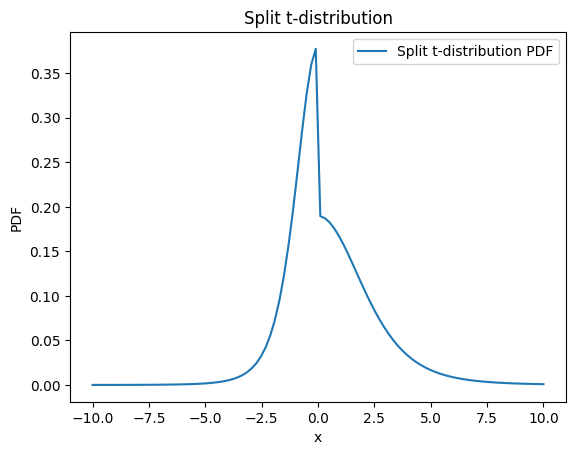

In [17]:
import numpy as np
import math

# Helper function: t-distribution PDF (manual implementation)
def t_pdf(x, nu):
    # Coefficient part
    coef = math.gamma((nu + 1) / 2) / (math.sqrt(nu * np.pi) * math.gamma(nu / 2))
    # PDF computation
    pdf = coef * (1 + (x ** 2) / nu) ** (-(nu + 1) / 2)
    return pdf

# Split t-distribution PDF implementation
def split_t_pdf(x, mu, sigma1, sigma2, nu):
    if x < mu:
        return (1 / sigma1) * t_pdf((x - mu) / sigma1, nu)
    else:
        return (1 / sigma2) * t_pdf((x - mu) / sigma2, nu)

# Vectorized version for arrays
def split_t_pdf_vectorized(x, mu, sigma1, sigma2, nu):
    # Use np.where to apply the split logic for arrays
    pdf = np.where(x < mu,
                   (1 / sigma1) * t_pdf((x - mu) / sigma1, nu),
                   (1 / sigma2) * t_pdf((x - mu) / sigma2, nu))
    return pdf

# Test the implementation
x_values = np.linspace(-10, 10, 100)
mu = 0
sigma1 = 1
sigma2 = 2
nu = 5

# Calculate the PDF values
pdf_values = [split_t_pdf(x, mu, sigma1, sigma2, nu) for x in x_values]

# Plot the PDF values for visual verification
import matplotlib.pyplot as plt
plt.plot(x_values, pdf_values, label="Split t-distribution PDF")
plt.title("Split t-distribution")
plt.xlabel("x")
plt.ylabel("PDF")
plt.legend()
plt.show()


In [18]:
def calculate_log_likelihood_split_normal(y, h, theta, sigma1, sigma2):
    mu_param, phi, sigma_eta = theta
    n = len(y)
    log_likelihood = 0.0
    
    for t in range(n):
        # Split Normal PDF for returns
        if y[t] < 0:
            pdf = (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (y[t] / sigma1) ** 2)
        else:
            pdf = (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (y[t] / sigma2) ** 2)
        
        log_likelihood += np.log(pdf + 1e-10)  # Adding small value to prevent log(0)
        
        # Volatility process likelihood
        if t == 0:
            var0 = sigma_eta ** 2 / (1 - phi ** 2)
            log_prior = -0.5 * np.log(2 * np.pi * var0) - ((y[t] - mu_param) ** 2) / (2 * var0)
        else:
            mean_ht = mu_param + phi * (h[t-1] - mu_param)
            log_prior = -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t] - mean_ht) ** 2) / (2 * sigma_eta ** 2)
        
        log_likelihood += log_prior
    
    return log_likelihood

def calculate_log_likelihood_split_t(y, h, theta, sigma1, sigma2, nu):
    mu_param, phi, sigma_eta = theta
    n = len(y)
    log_likelihood = 0.0
    
    for t in range(n):
        # Split t PDF for returns
        if y[t] < 0:
            pdf = (1 / sigma1) * t.pdf(y[t] / sigma1, df=nu)
        else:
            pdf = (1 / sigma2) * t.pdf(y[t] / sigma2, df=nu)
        
        log_likelihood += np.log(pdf + 1e-10)  # Adding small value to prevent log(0)
        
        # Volatility process likelihood
        if t == 0:
            var0 = sigma_eta ** 2 / (1 - phi ** 2)
            log_prior = -0.5 * np.log(2 * np.pi * var0) - ((y[t] - mu_param) ** 2) / (2 * var0)
        else:
            mean_ht = mu_param + phi * (h[t-1] - mu_param)
            log_prior = -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t] - mean_ht) ** 2) / (2 * sigma_eta ** 2)
        
        log_likelihood += log_prior
    
    return log_likelihood


In [19]:
def gibbs_sampler_split_normal(y, iterations, burn_in, priors, initial_params, sigma1, sigma2):
    """
    Perform Gibbs sampling for the SV model with Split Normal returns.
    
    Parameters:
    - y: Observed log returns (numpy array)
    - iterations: Total number of MCMC iterations
    - burn_in: Number of burn-in iterations
    - priors: Dictionary containing prior parameters
    - initial_params: Dictionary containing initial parameter values
    - sigma1: Scale parameter for y_t < 0
    - sigma2: Scale parameter for y_t >= 0
    
    Returns:
    - samples: Dictionary containing sampled parameters and latent volatilities
    """
    n = len(y)
    
    # Unpack priors
    mu_prior_mean = priors['mu_mean']
    mu_prior_std = priors['mu_std']
    
    phi_prior_a = priors['phi_a']
    phi_prior_b = priors['phi_b']
    
    sigma_eta_prior_alpha = priors['sigma_eta_alpha']
    sigma_eta_prior_beta = priors['sigma_eta_beta']
    
    # Initialize parameters
    mu = initial_params['mu']
    phi = initial_params['phi']
    sigma_eta = initial_params['sigma_eta']
    
    # Initialize latent volatilities
    h = np.zeros(n)
    h[0] = np.random.normal(mu, sigma_eta / np.sqrt(1 - phi ** 2))
    for t in range(1, n):
        h[t] = mu + phi * (h[t-1] - mu) + np.random.normal(0, sigma_eta)
    
    # Store samples
    samples_mu = []
    samples_phi = []
    samples_sigma_eta = []
    samples_h = []
    
    for it in range(iterations):
        # --- Step 1: Sample h_t given mu, phi, sigma_eta, y ---
        # Using a simple Metropolis-Hastings step for each h_t
        for t in range(n):
            # Current h_t
            current_ht = h[t]
            
            # Propose a new h_t
            proposal_ht = np.random.normal(current_ht, 0.1)  # Proposal variance can be tuned
            
            # Calculate log-likelihood ratio
            # For returns
            if y[t] < 0:
                log_likelihood_current = -0.5 * np.log(2 * np.pi * (sigma1 ** 2)) - (y[t] ** 2) / (2 * (sigma1 ** 2))
                log_likelihood_proposal = -0.5 * np.log(2 * np.pi * (sigma1 ** 2)) - (y[t] ** 2) / (2 * (sigma1 ** 2))
            else:
                log_likelihood_current = -0.5 * np.log(2 * np.pi * (sigma2 ** 2)) - (y[t] ** 2) / (2 * (sigma2 ** 2))
                log_likelihood_proposal = -0.5 * np.log(2 * np.pi * (sigma2 ** 2)) - (y[t] ** 2) / (2 * (sigma2 ** 2))
            
            # Adjust log-likelihood for volatility process
            if t == 0:
                var0 = sigma_eta ** 2 / (1 - phi ** 2)
                log_prior_current = -0.5 * np.log(2 * np.pi * var0) - ((h[t] - mu) ** 2) / (2 * var0)
                log_prior_proposal = -0.5 * np.log(2 * np.pi * var0) - ((proposal_ht - mu) ** 2) / (2 * var0)
            else:
                mean_ht = mu + phi * (h[t-1] - mu)
                log_prior_current = -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t] - mean_ht) ** 2) / (2 * sigma_eta ** 2)
                log_prior_proposal = -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((proposal_ht - mean_ht) ** 2) / (2 * sigma_eta ** 2)
            
            # For t > 0, consider h_{t+1}
            if t < n - 1:
                mean_ht_plus = mu + phi * (h[t] - mu)
                log_prior_current += -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t+1] - mu - phi * (h[t] - mu)) ** 2) / (2 * sigma_eta ** 2)
                mean_ht_plus_proposal = mu + phi * (proposal_ht - mu)
                log_prior_proposal += -0.5 * np.log(2 * np.pi * sigma_eta ** 2) - ((h[t+1] - mu - phi * (proposal_ht - mu)) ** 2) / (2 * sigma_eta ** 2)
            
            # Compute acceptance probability
            log_accept_ratio = (log_likelihood_proposal + log_prior_proposal) - (log_likelihood_current + log_prior_current)
            accept_ratio = np.exp(log_accept_ratio)
            alpha = min(1, accept_ratio)
            
            # Accept or reject
            if np.random.uniform(0, 1) < alpha:
                h[t] = proposal_ht  # Accept the proposal
        
        # --- Step 2: Sample mu given h, phi, sigma_eta ---
        # Conditional posterior of mu is Normal
        # Derive mean and variance
        sum_h = np.sum(h[1:] - phi * h[:-1])
        var_mu = 1 / (1 / (mu_prior_std ** 2) + phi ** 2 * (n - 1) / (sigma_eta ** 2))
        mean_mu = var_mu * (mu_prior_mean / (mu_prior_std ** 2) + phi * sum_h / (sigma_eta ** 2))
        mu = np.random.normal(mean_mu, np.sqrt(var_mu))
        
        # --- Step 3: Sample phi given h, mu, sigma_eta ---
        # Use Metropolis-Hastings for phi
        current_phi = phi
        proposal_phi = np.random.normal(current_phi, 0.01)  # Proposal std can be tuned
        
        # Ensure phi is in (-1, 1)
        if proposal_phi <= -1 or proposal_phi >= 1:
            proposal_phi = current_phi
        
        # Calculate log-posterior for current and proposal
        log_prior_current_phi = (phi_prior_a - 1) * np.log((current_phi + 1) / 2) + (phi_prior_b - 1) * np.log((1 - current_phi) / 2)
        log_prior_proposal_phi = (phi_prior_a - 1) * np.log((proposal_phi + 1) / 2) + (phi_prior_b - 1) * np.log((1 - proposal_phi) / 2)
        
        # Likelihood based on h
        residual_current = h[1:] - mu - current_phi * (h[:-1] - mu)
        residual_proposal = h[1:] - mu - proposal_phi * (h[:-1] - mu)
        
        log_likelihood_current_phi = -0.5 * np.sum((residual_current ** 2) / (sigma_eta ** 2))
        log_likelihood_proposal_phi = -0.5 * np.sum((residual_proposal ** 2) / (sigma_eta ** 2))
        
        # Compute acceptance probability
        log_accept_ratio_phi = (log_likelihood_proposal_phi + log_prior_proposal_phi) - (log_likelihood_current_phi + log_prior_current_phi)
        accept_ratio_phi = np.exp(log_accept_ratio_phi)
        alpha_phi = min(1, accept_ratio_phi)
        
        # Accept or reject
        if np.random.uniform(0, 1) < alpha_phi:
            phi = proposal_phi
        
        # --- Step 4: Sample sigma_eta given h, mu, phi ---
        # Conditional posterior of sigma_eta^2 is Gamma
        residuals = h[1:] - mu - phi * (h[:-1] - mu)
        shape_post = sigma_eta_prior_alpha + (len(residuals) / 2)
        rate_post = sigma_eta_prior_beta + 0.5 * np.sum(residuals ** 2)
        sigma_eta_sq = np.random.gamma(shape_post, 1 / rate_post)
        sigma_eta = np.sqrt(sigma_eta_sq)
        
        # Store samples after burn-in
        if it >= burn_in:
            samples_mu.append(mu)
            samples_phi.append(phi)
            samples_sigma_eta.append(sigma_eta)
            samples_h.append(h.copy())
        
        # Optional: Print progress
        if (it + 1) % 1000 == 0:
            print(f"Iteration {it + 1} completed.")
    
    # Convert samples_h to a NumPy array for easier handling
    samples_h = np.array(samples_h)
    
    # Return the collected samples
    samples = {
        'mu': np.array(samples_mu),
        'phi': np.array(samples_phi),
        'sigma_eta': np.array(samples_sigma_eta),
        'h': samples_h
    }
    
    return samples


In [20]:
# Define split normal parameters
sigma1 = 0.5  # Scale for y_t < 0
sigma2 = 0.5  # Scale for y_t >= 0

# Update prior parameters if needed (can keep the same)
priors_split = priors  # Using the same priors

# Initial parameter guesses
initial_params_split = initial_params.copy()

# Set MCMC parameters
iterations_split = 10000
burn_in_split = 2000

# Run Gibbs sampler with Split Normal
print("Starting Gibbs sampler with Split Normal...")
samples_split = gibbs_sampler_split_normal(y, iterations_split, burn_in_split, priors_split, initial_params_split, sigma1, sigma2)
print("Gibbs sampler with Split Normal completed.")


Starting Gibbs sampler with Split Normal...
Iteration 1000 completed.
Iteration 2000 completed.
Iteration 3000 completed.
Iteration 4000 completed.
Iteration 5000 completed.
Iteration 6000 completed.
Iteration 7000 completed.
Iteration 8000 completed.
Iteration 9000 completed.
Iteration 10000 completed.
Gibbs sampler with Split Normal completed.


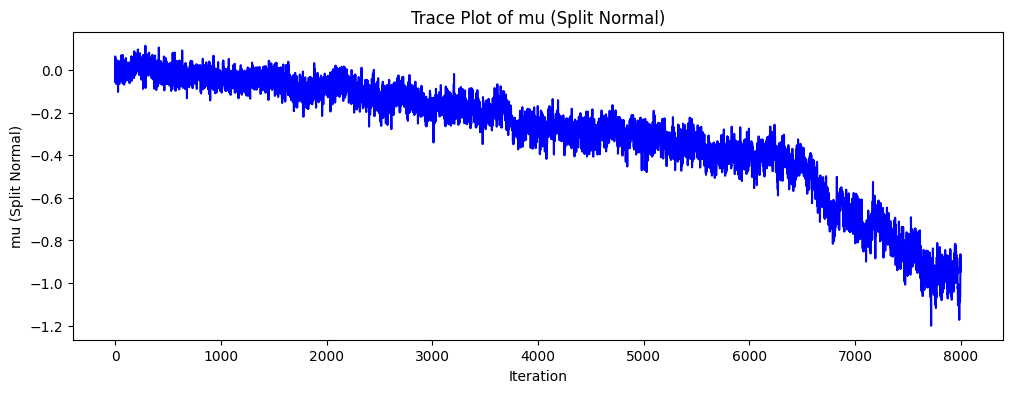

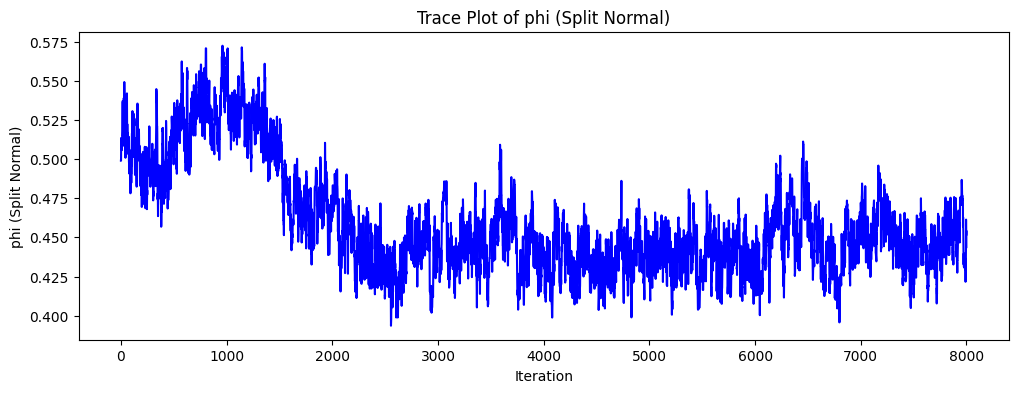

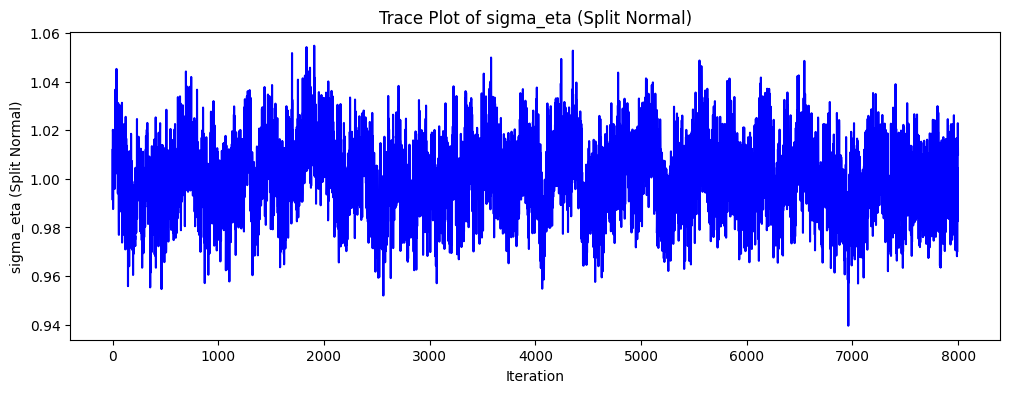

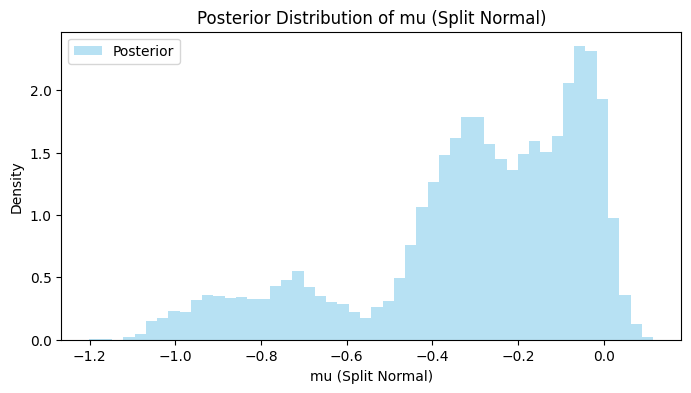

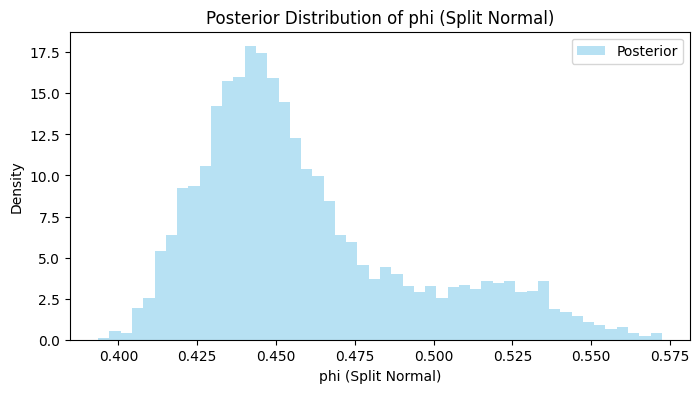

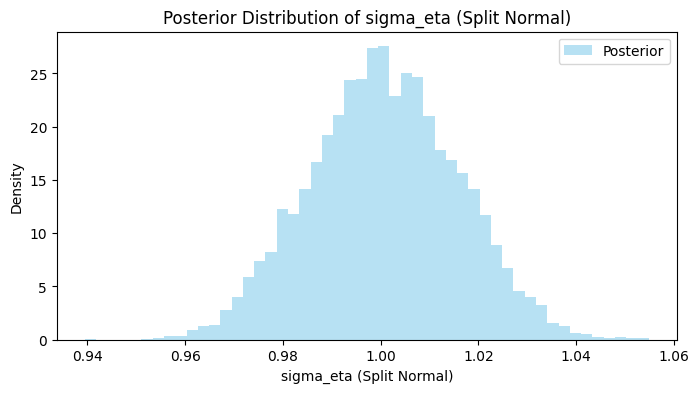

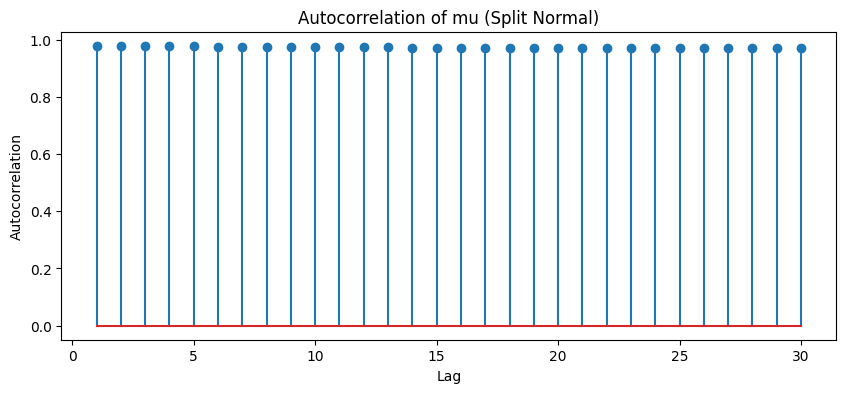

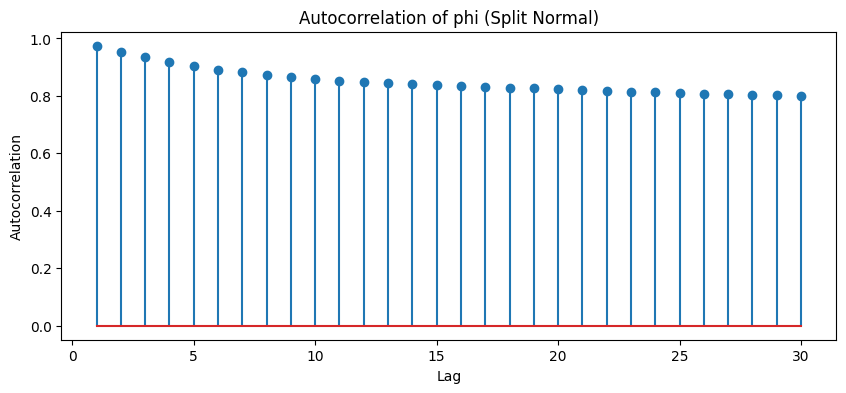

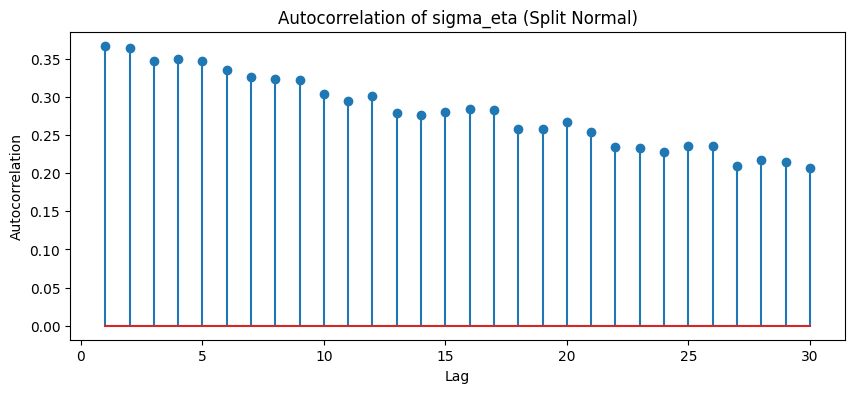

In [21]:
# Plot trace plots
plot_trace(samples_split['mu'], 'mu (Split Normal)')
plot_trace(samples_split['phi'], 'phi (Split Normal)')
plot_trace(samples_split['sigma_eta'], 'sigma_eta (Split Normal)')

# Plot posterior distributions
plot_posterior(samples_split['mu'], 'mu (Split Normal)')
plot_posterior(samples_split['phi'], 'phi (Split Normal)')
plot_posterior(samples_split['sigma_eta'], 'sigma_eta (Split Normal)')

# Plot autocorrelation
plot_autocorrelation(samples_split['mu'], 'mu (Split Normal)')
plot_autocorrelation(samples_split['phi'], 'phi (Split Normal)')
plot_autocorrelation(samples_split['sigma_eta'], 'sigma_eta (Split Normal)')
